In [90]:
# import statsmodels.tsa as tsa
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

%matplotlib inline

def autocorrelation(x): #todo flatten with mean
    result = np.correlate(x,x,mode="full")
    return result[result.size//2:result.size//2+30]

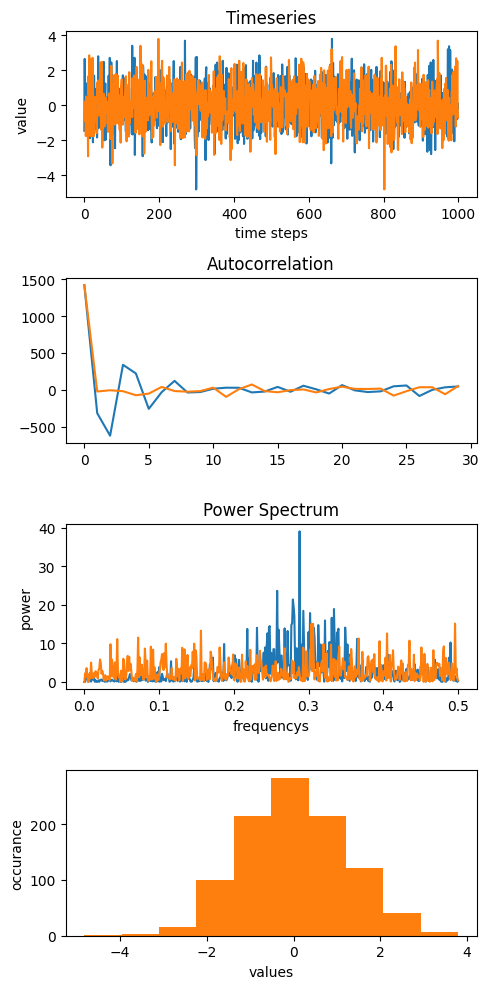

In [103]:
# creating an AR2 Timeseries
ar2 = np.array([1,0.33,0.5])
ma = np.array([1])

ar2_data = ArmaProcess(ar2,ma).generate_sample(nsample=1000)
# plt.title("Ar(2) generated time series")
# plt.plot(ar2_data)
# plt.show()

# autcorr_ar2 = autocorrelation(ar2_data)
# plt.title("autocorrelation")
# plt.plot(autcorr_ar2)
# plt.show()

def get_frequencys(time_series):
    freq = np.fft.fft(time_series)
    return freq

def plot_surrogates(time_series, surrogate_method):
    time_series_surrogate = surrogate_method(time_series)
    fig, axs = plt.subplots(4, )
    fig.set_size_inches(5,10)
    axs[0].set_title("Timeseries")
    axs[0].plot(time_series)
    axs[0].plot(time_series_surrogate)
    axs[0].set_xlabel("time steps")
    axs[0].set_ylabel("value")
    axs[1].set_title("Autocorrelation")
    axs[1].plot(autocorrelation(time_series))
    axs[1].plot(autocorrelation(time_series_surrogate))
    axs[2].set_title("Power Spectrum")
    f, Pxx = ss.periodogram(time_series) # calculate power spectrum
    axs[2].plot(f, Pxx)
    f_s, Pxx_s = ss.periodogram(time_series_surrogate)
    axs[2].plot(f_s, Pxx_s)
    axs[2].set_xlabel("frequencys")
    axs[2].set_ylabel("power")
    axs[3].hist(time_series)
    axs[3].hist(time_series_surrogate)
    axs[3].set_xlabel("values")
    axs[3].set_ylabel("occurance")

    fig.tight_layout()
    plt.plot()
    return
    




Random Shuffle Surrogates (RS)

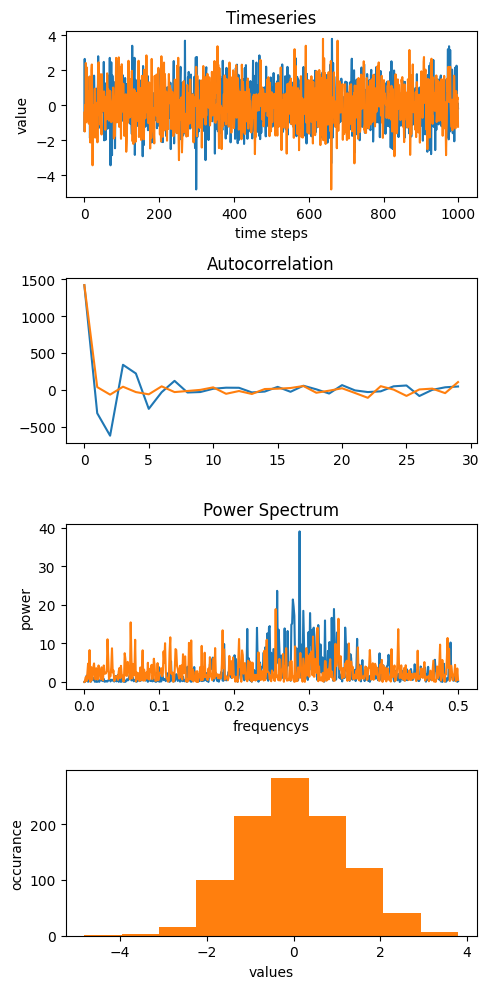

In [104]:
def RS(timeseries):
    """
        shuffles the values of the time series
    """
    RS_surrogate = np.copy(timeseries)
    np.random.shuffle(RS_surrogate)
    return RS_surrogate

plot_surrogates(ar2_data, RS)


In [105]:
def FS(timeseries):
    ft = np.fft.fft(timeseries)
    phase = np.angle(ft) #phase of the complex fourier values
    amp = np.abs(ft) # amplitudes of the complex fourier values
    print(phase)

FS(ar2_data)

[ 0.00000000e+00  3.12619767e+00 -1.03855072e-01 -9.97681940e-01
  2.88758762e-01  2.25456421e+00  1.72767228e+00  1.26402822e+00
  1.05227430e+00  4.10004327e-02  1.60784169e+00 -1.62160465e-01
 -3.01036287e+00 -2.83250164e+00  7.40398109e-01 -2.98281601e+00
 -3.09087129e+00  1.62469739e+00  3.56933423e-01  2.53050396e-01
  2.35018650e+00 -2.05356972e-01 -9.66848548e-01  3.09816776e+00
  2.03708897e+00  2.26607801e+00 -7.83477736e-01  1.03115795e+00
 -2.06036558e-01 -1.09145451e+00 -1.80590552e+00 -2.33196172e+00
 -1.97997565e+00 -2.66316840e+00  2.02263608e+00 -1.00539290e+00
  2.46779430e+00 -2.21200907e+00 -1.27571082e+00 -8.23996881e-01
  2.67187938e+00  1.39841715e+00  5.34009054e-01 -2.79134316e+00
  1.26950183e+00  7.77700725e-01  1.59194613e+00 -1.39390283e+00
  2.82001577e+00 -8.28890143e-01 -2.43355850e+00 -2.95781201e+00
 -2.87110194e+00 -2.39473539e+00 -2.48549006e+00  2.30163003e-01
 -1.72713724e+00  8.79130280e-01  1.71034487e+00 -8.60646718e-01
 -6.23337348e-01  2.01575